<a href="https://colab.research.google.com/github/sajidcsecu/radioGenomic/blob/main/UnetinGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall pydicom

Found existing installation: pydicom 3.0.1
Uninstalling pydicom-3.0.1:
  Would remove:
    /usr/local/bin/pydicom
    /usr/local/lib/python3.11/dist-packages/pydicom-3.0.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/pydicom/*
Proceed (Y/n)? y
  Successfully uninstalled pydicom-3.0.1


In [ ]:
!pip install pydicom==2.4.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.3 MB/s eta 0:00:00


In [ ]:
import pydicom
print(pydicom.__version__)

2.4.2


In [ ]:
!pip install --upgrade pydicom-seg

In [ ]:
import pydicom
import pydicom._storage_sopclass_uids
print("Fixed!")

Fixed!


In [ ]:
!pip install torchinfo

In [ ]:
!pip install pyradiomics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 30.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73

In [ ]:
import radiomics
print(radiomics.__version__)

v3.0.1


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pydicom
import pydicom_seg
import pydicom._storage_sopclass_uids
from radiomics import imageoperations
from torch.utils.data import Dataset,DataLoader
import os
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import SimpleITK as sitk
from torchinfo import summary
import torch.optim.lr_scheduler as lr_scheduler
from torch.cuda.amp import autocast, GradScaler
import csv
import time
import random
from tqdm import tqdm
from operator import add
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
sitk.ProcessObject_SetGlobalWarningDisplay(False)

Mounted at /content/drive


/content/drive/MyDrive/PhD work


In [6]:
pwd

'/content/drive/MyDrive/PhD work'

/content/drive/MyDrive/PhD work
------------
| METADATA |
------------
./metadata/metadata_lung1.csv
LUNG1-002
   Modality  Number of Images  \
2       SEG                 1   
3  RTSTRUCT                 1   
6        CT               111   

                                       File Location  
2  .\NSCLC-Radiomics\LUNG1-002\01-01-2014-StudyID...  
3  .\NSCLC-Radiomics\LUNG1-002\01-01-2014-StudyID...  
6  .\NSCLC-Radiomics\LUNG1-002\01-01-2014-StudyID...  

------
| CT |
------
6    .\NSCLC-Radiomics\LUNG1-002\01-01-2014-StudyID...
Name: File Location, dtype: object
CT Folder in windows style :  .\NSCLC-Radiomics\LUNG1-002\01-01-2014-StudyID-NA-85095\1.000000-NA-61228
CT Folder in unix style :  ./NSCLC-Radiomics/LUNG1-002/01-01-2014-StudyID-NA-85095/1.000000-NA-61228
File Names :  ('./NSCLC-Radiomics/LUNG1-002/01-01-2014-StudyID-NA-85095/1.000000-NA-61228/1-111.dcm', './NSCLC-Radiomics/LUNG1-002/01-01-2014-StudyID-NA-85095/1.000000-NA-61228/1-110.dcm', './NSCLC-Radiomics/LUNG1-002/0

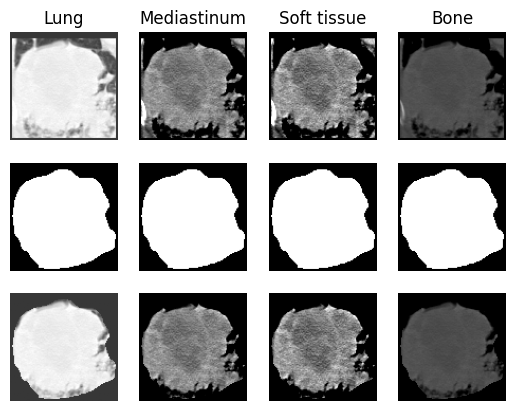

In [13]:
class RadioImage:

    def read_dicom_ct(self, subject):
        """Read a folder with DICOM files and outputs a SimpleITK image.
        Assumes that there is only one DICOM series in the folder.

        Parameters
        ----------
        folder : string
        Full path to folder with dicom files.

        Returns
        -------
        SimpleITK image.
        """
        subject_ct = subject[subject['Modality'] == 'CT']
        print(subject_ct['File Location'])
        ct_folder = subject_ct['File Location'].iloc[0]
        print("CT Folder in windows style : ",ct_folder)
        ct_num = subject_ct['Number of Images'].iloc[0]
        #print('Number of slices:', ct_num)
        reader = sitk.ImageSeriesReader()
        reader.SetImageIO("GDCMImageIO")
        #series_ids = reader.GetGDCMSeriesIDs(ct_folder)
        #print("Series Ids : ", series_ids)
        #  There are multiple series_ids in the folder, but after experimenting a bit,
        # we pick the second one, this is [1] below.
        ct_folder = os.path.normpath(ct_folder)
        ct_folder = ct_folder.replace("\\", "/")
        print("CT Folder in unix style : ", ct_folder)
        filenames = reader.GetGDCMSeriesFileNames(ct_folder)
        # filenames = reader.GetGDCMSeriesFileNames(ct_folder, "",
        #                                           False,  # useSeriesDetails
        #                                           False,  # recursive
        #                                           False)  # load sequences
        print("File Names : ", filenames)
        reader.SetFileNames(filenames)
        image = reader.Execute()
        #print("Size : ",image.GetSize())
        #print("Origin : ", image.GetOrigin())
        #print("Spacing : ",image.GetSpacing())
        #print("Direction : ",image.GetDirection())
        #print(image)

        return image

    def read_dicom_seg(self,subject,seg_type):
        """Read a folder with DICOM files and outputs a SimpleITK image.
        Assumes that there is only one DICOM series in the folder.

        Parameters
        ----------
        folder : string
        Full path to folder with dicom files.

        Returns
        -------
        SimpleITK image.
        """
        subject_seg = subject[subject['Modality'] == 'SEG']
        segmentation_path = subject_seg['File Location'].iloc[0]
        segmentation_path = os.path.normpath(segmentation_path)
        segmentation_path = segmentation_path.replace("\\", "/")
        segmentation = pydicom.dcmread(os.path.join(segmentation_path, '1-1.dcm'))  # always 1-1.dcm
        #Segment Description
        seg_fields = ['SegmentNumber', 'SegmentDescription']  # Segment Number and Segment Description are enough for us
        # see https://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.8.20.4.html
        segments = segmentation.SegmentSequence
        seg_dict = {f: [s[f].value for s in segments] for f in seg_fields}
        seg_df = pd.DataFrame(seg_dict)  # dataframe conversion for easier handling
        # print('Segments:')
        # print(seg_df)
        # print()
        seg = seg_df[seg_df['SegmentDescription'] == seg_type]
        # print(seg)
        seg_number = seg['SegmentNumber'].iloc[0]
        print(seg_number)
        #Reading Segments
        reader = pydicom_seg.SegmentReader()
        # print("Reader : ", reader)
        result = reader.read(segmentation)
        #print("Result : ", result)
        image = result.segment_image(seg_number)
        #print("Result : ", type(image))
        return image

    def read_dicom_test_retest_ct(self,subject,subject_type):
        """Read a folder with DICOM files and outputs a SimpleITK image.
        Assumes that there is only one DICOM series in the folder.

        Parameters
        ----------
        folder : string
        Full path to folder with dicom files.

        Returns
        -------
        SimpleITK image.
        """
        subject_ct_tr = subject[subject['Modality'] == 'CT']
        print(subject_ct_tr[['Modality', 'Number of Images', 'File Location', 'Subject Type']])
        print()
        subject_ct = subject_ct_tr[subject_ct_tr['Subject Type'] == subject_type]
        print(subject_ct)
        #print(subject_ct['File Location'])
        ct_folder = subject_ct['File Location'].iloc[0]
        #print("CT Folder : ",ct_folder)
        ct_num = subject_ct['Number of Images'].iloc[0]
        #print('Number of slices:', ct_num)
        reader = sitk.ImageSeriesReader()
        #series_ids = reader.GetGDCMSeriesIDs(ct_folder)
        #print("Series Ids : ", series_ids)
    #  There are multiple series_ids in the folder, but after experimenting a bit,
    # we pick the second one, this is [1] below.
        filenames = reader.GetGDCMSeriesFileNames(ct_folder, "",
                                              False,  # useSeriesDetails
                                              False,  # recursive
                                              False)  # load sequences
        #print("File Names : ", filenames)
        reader.SetFileNames(filenames)
        image = reader.Execute()
        #print(image)

        return image

    def read_dicom_test_retest_seg(self,subject,subject_type,seg_type):
        """Read a folder with DICOM files and outputs a SimpleITK image.
        Assumes that there is only one DICOM series in the folder.

        Parameters
        ----------
        folder : string
        Full path to folder with dicom files.

        Returns
        -------
        SimpleITK image.
        """
        subject_seg_rt = subject[subject['Modality'] == 'SEG']
        print(subject_seg_rt)
        print()
        subject_seg = subject_seg_rt[subject_seg_rt['Subject Type'] == subject_type]
        print(subject_seg)
        print()
        segmentation_path = subject_seg['File Location'].iloc[0]
        segmentation = pydicom.dcmread(os.path.join(segmentation_path, '1-1.dcm'))  # always 1-1.dcm
        #Segment Description
        seg_fields = ['SegmentNumber', 'SegmentDescription']  # Segment Number and Segment Description are enough for us
        # see https://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.8.20.4.html
        segments = segmentation.SegmentSequence
        seg_dict = {f: [s[f].value for s in segments] for f in seg_fields}
        seg_df = pd.DataFrame(seg_dict)  # dataframe conversion for easier handling
        print('Segments:')
        print(seg_df)
        print()
        seg = seg_df[seg_df['SegmentDescription'] == seg_type]
        print(seg)
        seg_number = seg['SegmentNumber'].iloc[0]
        print(seg_number)
        #Reading Segments
        reader = pydicom_seg.SegmentReader()
        print("Reader : ", reader)
        result = reader.read(segmentation)
        #print("Result : ", result)
        image = result.segment_image(seg_number)
        #print("Result : ", type(image))
        return image

    def display(self,image,mask,seg_type):
        ct_pixels = sitk.GetArrayFromImage(image)
        seg_pixels = sitk.GetArrayFromImage(mask)
        #print(image)
        idx = np.argmax(np.sum(seg_pixels, axis=(1, 2)))
        ct_frame = ct_pixels[idx, :, :]
        seg_frame = seg_pixels[idx, :, :]
        combined_frame = np.copy(ct_frame)
        combined_frame[seg_frame == 0] = ct_frame.min()
        print("----Combined Image----")
        print('Selected frame:', idx)
        print("Max Intensity : ", np.max(combined_frame))
        print("Min Intensity : ", np.min(combined_frame))
        # Windows
        windows = pd.DataFrame({ \
            'Window': ['Lung', 'Mediastinum', 'Soft tissue', 'Bone'], \
            'Width': [1500, 350, 250, 1800], \
            'Level': [-600, 50, 50, 400], \
            })
        n_windows = len(windows)
        print('Windows:')
        print(windows)
        plt.figure(seg_type)
        plt.style.use('grayscale')
        for i in range(n_windows):
            # window range
            W = windows['Width'][i]
            L = windows['Level'][i]
            vmin = L - W // 2
            vmax = L + W // 2
            # CT frame
            plt.subplot(3, n_windows, i + 1)
            plt.imshow(ct_frame, vmin=vmin, vmax=vmax)
            plt.axis('off')
            plt.title(windows['Window'][i])
            # Segmentation frame
            plt.subplot(3, n_windows, i + n_windows + 1)
            plt.imshow(seg_frame)
            plt.axis('off')
            # Combined frame
            plt.subplot(3, n_windows, i + 2 * n_windows + 1)
            plt.imshow(combined_frame, vmin=vmin, vmax=vmax)
            plt.axis('off')
        plt.show()

    def view(self, image, mask, seg_type,name):
            ct_pixels = sitk.GetArrayFromImage(image)
            seg_pixels = sitk.GetArrayFromImage(mask)
            #r,c,s = img.shape
            print("The Number of Slices : ")
            r,c,s= image.GetSize()
            print(image.GetSize())
            #print(range(s))
            #nda = sitk.GetArrayFromImage(image)
            #plt.imshow(nda[21, :, :])
            # print(image)
            #idx = np.argmax(np.sum(seg_pixels, axis=(1, 2)))

            # Windows
            windows = pd.DataFrame({ \
                'Window': ['Lung', 'Mediastinum', 'Soft tissue', 'Bone'], \
                'Width': [1500, 350, 250, 1800], \
                'Level': [-600, 50, 50, 400], \
                })
            n_windows = s
            print('Windows:')
            print(windows)
            plt.figure(seg_type)
            plt.style.use('grayscale')
            for idx in range(n_windows):
                #print(idx)
                # window range
                ct_frame = ct_pixels[idx, :, :]
                seg_frame = seg_pixels[idx, :, :]
                combined_frame = np.copy(ct_frame)
                combined_frame[seg_frame == 0] = ct_frame.min()
                W = windows['Width'][0]
                L = windows['Level'][0]
                vmin = L - W // 2
                vmax = L + W // 2
                # CT frame
                plt.subplot(3, n_windows, idx + 1)
                #plt.subplots_adjust(left=0.2, bottom=0.2, right=0.3, top=0.3, wspace=0.2, hspace=0.2)
                plt.imshow(ct_frame, vmin=vmin, vmax=vmax)
                plt.axis('off')
                plt.title(f"Slice {idx+1}")
                # Segmentation frame
                plt.subplot(3, n_windows, idx + n_windows + 1)
                #plt.subplots_adjust(left=0.2, bottom=0.2, right=0.3, top=0.3, wspace=0.2, hspace=0.2)
                plt.imshow(seg_frame)
                plt.axis('off')
                # Combined frame
                plt.subplot(3, n_windows, idx + 2 * n_windows + 1)

                plt.imshow(combined_frame, vmin=vmin, vmax=vmax)
                plt.axis('off')

            plt.tight_layout()
            plt.subplots_adjust(left=0, right=1, bottom=0, top=0.8, wspace=0, hspace=0.05)
            #plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.3, hspace=0.4)
            plt.savefig(name, format="pdf", bbox_inches="tight")
            plt.show()

    def gen_fig(self,image, mask, seg_type,name, min_value):
        ct_pixels = sitk.GetArrayFromImage(image)
        seg_pixels = sitk.GetArrayFromImage(mask)
        # r,c,s = img.shape
        print("The Number of Slices : ")
        r, c, s = image.GetSize()
        print(image.GetSize())
        # print(range(s))
        # nda = sitk.GetArrayFromImage(image)
        # plt.imshow(nda[21, :, :])
        # print(image)
        # idx = np.argmax(np.sum(seg_pixels, axis=(1, 2)))

        # Windows
        windows = pd.DataFrame({ \
            'Window': ['Lung', 'Mediastinum', 'Soft tissue', 'Bone'], \
            'Width': [1500, 350, 250, 1800], \
            'Level': [-600, 50, 50, 400], \
            })
        n_windows = s
        print('Windows:')
        print(windows)
        plt.figure(seg_type)
        plt.style.use('grayscale')
        for idx in range(n_windows):
            # print(idx)
            # window range
            ct_frame = ct_pixels[idx, :, :]
            seg_frame = seg_pixels[idx, :, :]
            combined_frame = np.copy(ct_frame)
            combined_frame[seg_frame == 0] = min_value #ct_frame.min()
            W = windows['Width'][0]
            L = windows['Level'][0]
            vmin = L - W // 2
            vmax = L + W // 2
                     # Combined frame
            plt.subplot(3, n_windows, idx + 2 * n_windows + 1)
            plt.imshow(combined_frame, vmin=vmin, vmax=vmax)
            #.title(f"Slice {idx + 1}")
            plt.axis('off')

        plt.tight_layout()
        plt.subplots_adjust(left=0, right=1, bottom=0, top=0.8, wspace=0, hspace=0.05)
        # plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.3, hspace=0.4)
        plt.savefig(name, format="pdf", bbox_inches="tight")
        plt.show()

    def array_to_sitk(self,image, mask, croppedImagearray,croppedmaskarray):
        finalImage = sitk.GetImageFromArray(np.array(croppedImagearray))
        finalmask = sitk.GetImageFromArray(np.array(croppedmaskarray))
        # image_bad_header_itk = sitk.ReadImage(rimage)
        # image_good_header = sitk.ReadImage(sitkimage)
        #
        # finalImage.CopyInformation(croppedImage)
        finalImage.SetDirection(image.GetDirection())
        finalImage.SetOrigin(image.GetOrigin())
        finalImage.SetSpacing(image.GetSpacing())
        [finalImage.SetMetaData(key, image.GetMetaData(key)) for key in image.GetMetaDataKeys()]

        # finalImask.CopyInformation(croppedMask)
        finalmask.SetDirection(mask.GetDirection())
        finalmask.SetOrigin(mask.GetOrigin())
        finalmask.SetSpacing(mask.GetSpacing())
        [finalmask.SetMetaData(key,mask.GetMetaData(key)) for key in mask.GetMetaDataKeys()]
        return finalImage, finalmask

    def crop_image1(self, image, mask, **settings):
        # Resample if necessary
        interpolator = settings.get('interpolator')
        resampledPixelSpacing = settings.get('resampledPixelSpacing')
        if interpolator is not None and resampledPixelSpacing is not None:
            image, mask = imageoperations.resampleImage(image, mask, **settings)

        # Crop the image
        # bb is the bounding box, upon which the image and mask are cropped
        bb, correctedMask = imageoperations.checkMask(image, mask, **settings)
        # print(bb)
        if correctedMask is not None:
            mask = correctedMask
        # print("Corrected Image : ", sitk.GetArrayFromImage(mask))
        croppedImage, croppedMask = imageoperations.cropToTumorMask(image, mask, bb)
        croppedImagearray = sitk.GetArrayFromImage(croppedImage)
        croppedmaskarray = sitk.GetArrayFromImage(croppedMask)
        print(croppedImagearray.shape)
        print(croppedmaskarray.shape)
        # Deleting empty slices
        slices, row, column = croppedImagearray.shape
        idx_empty_slice = [idx for idx in range(slices) if np.count_nonzero(croppedmaskarray[idx, :, :]) == 0]
        croppedmaskarray = np.delete(croppedmaskarray, idx_empty_slice, axis=0)
        croppedImagearray = np.delete(croppedImagearray, idx_empty_slice, axis=0)
        if row > column:
            padding = ((0, 0), (0, 0), (0, (row - column)))
        else:
            padding = ((0, 0), ((column - row), 0), (0, 0))

        croppedImagearray = np.pad(croppedImagearray, padding, constant_values=np.min(croppedImagearray))
        croppedmaskarray = np.pad(croppedmaskarray, padding, constant_values=np.min(croppedmaskarray))
        slice, row, column = croppedImagearray.shape
        if (row%2) !=0:
            padding = ((0, 0), (1, 0), (0, 1))
            croppedImagearray = np.pad(croppedImagearray, padding, constant_values=np.min(croppedImagearray))
            croppedmaskarray = np.pad(croppedmaskarray, padding, constant_values=np.min(croppedmaskarray))

        #print(croppedImagearray.shape)
        #print(croppedmaskarray.shape)

        finalImage = sitk.GetImageFromArray(np.array(croppedImagearray))
        finalmask = sitk.GetImageFromArray(np.array(croppedmaskarray))
        # image_bad_header_itk = sitk.ReadImage(rimage)
        # image_good_header = sitk.ReadImage(sitkimage)
        #
        #finalImage.CopyInformation(croppedImage)
        finalImage.SetDirection(croppedImage.GetDirection())
        finalImage.SetOrigin(croppedImage.GetOrigin())
        finalImage.SetSpacing(croppedImage.GetSpacing())
        [finalImage.SetMetaData(key, croppedImage.GetMetaData(key)) for key in croppedImage.GetMetaDataKeys()]

        #finalImask.CopyInformation(croppedMask)
        finalmask.SetDirection(croppedMask .GetDirection())
        finalmask.SetOrigin(croppedMask .GetOrigin())
        finalmask.SetSpacing(croppedMask.GetSpacing())
        [finalmask.SetMetaData(key, croppedMask.GetMetaData(key)) for key in croppedMask .GetMetaDataKeys()]
        return finalImage, finalmask

    def crop_image(self, img, msk):
        image = sitk.GetArrayFromImage(img)
        mask = sitk.GetArrayFromImage(msk)
        print()
        print("Before deleting Useless slices")
        print(image.shape)
        print(mask.shape)
        print(image.dtype)
        print(mask.dtype)
        # Deleting empty slices
        # slices, row, column = mask.shape
        # idx_empty_slice = [idx for idx in range(slices) if np.count_nonzero(mask[idx, :, :]) == 0]
        # mask = np.delete(mask, idx_empty_slice, axis=0)
        # image = np.delete(image, idx_empty_slice, axis=0)
        # Ensure the number of slices are the same
        num_slices_img, num_slices_mask = image.shape[0], mask.shape[0]

        if num_slices_img != num_slices_mask:
            print("Warning: The number of slices in the image and mask are not the same!")

        # Determine the minimum number of slices to avoid indexing errors
        min_slices = min(num_slices_img, num_slices_mask)

        # Adjust the image and mask to have the same number of slices
        image = image[:min_slices]
        mask = mask[:min_slices]

        # Find non-empty slices efficiently using np.any()
        non_empty_slices = np.any(mask, axis=(1, 2))  # Check if any pixel is non-zero along height & width
        image = image[non_empty_slices]
        mask = mask[non_empty_slices]
        # print("After deleting Useless slices")
        # print(image.shape)
        # print(mask.shape)
        slices, row, column = image.shape
        rx=[]
        ry=[]
        rw=[]
        rh=[]
        # plt.figure("CT")
        for idx in range(slices):
            contours, hierarchy = cv2.findContours(mask[idx,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            x, y, w, h = cv2.boundingRect(contours[0])
            rx.append(x)
            ry.append(y)
            rw.append(w)
            rh.append(h)
            #image[idx,:,:]= cv2.rectangle(image[idx,:,:], (x, y), (x + w, y + h), (0, 255, 0), 2)
            # plt.subplot(121)
            # plt.imshow(image[idx,:,:],cmap='gray', vmin=image.min(),vmax=image.max())
            # plt.title("CT")
            # plt.axis('off')
            # plt.subplot(122)
            # plt.imshow(mask[idx, :, :], cmap='gray', vmin=mask.min(), vmax=mask.max())
            # plt.title("Mask")
            # plt.axis('off')
            # plt.show()
        maxw=max(rw)
        # print("Max W : ",maxw)
        maxh=max(rh)
        # print("Max H : ", maxh)
        croppedImage = np.ones([slices,maxh,maxw])
        croppedMask = np.ones([slices,maxh,maxw], dtype=np.uint8)
        # print(croppedImage.shape)
        for idx in range(slices):
            croppedImage[idx, :, :] = image[idx,ry[idx]:ry[idx]+maxh,rx[idx]:rx[idx]+maxw]
            croppedMask[idx, :, :] = mask[idx,ry[idx]:ry[idx]+maxh,rx[idx]:rx[idx]+maxw]
            # plt.subplot(121)
            # plt.imshow(croppedImage[idx,:,:],cmap='gray', vmin=croppedImage.min(),vmax=croppedImage.max())
            # plt.title("CT")
            # plt.axis('off')
            # plt.subplot(122)
            # plt.imshow(croppedMask[idx, :, :], cmap='gray', vmin=croppedMask.min(), vmax=croppedMask.max())
            # plt.title("Mask")
            # plt.axis('off')
            # plt.show()
        # print(finalImage.shape)
        # print(finalMask.shape)
        # print(finalImage.dtype)
        # print(finalMask.dtype)
        #
        print("Shape of cropped image : ", croppedImage.shape)
        croppedImage = np.pad(croppedImage, ((0, 0), (2, 2), (2, 2)), constant_values=np.min(croppedImage))
        croppedMask = np.pad(croppedMask, ((0, 0), (2, 2), (2, 2)), constant_values=np.min(croppedMask))
        print("Shape of cropped image with padding 3 zeros : ", croppedImage.shape)
        slice, row, column = croppedImage.shape
        if row > column:
            padding = ((0, 0), (0, 0), (0, (row - column)))
        else :
            padding = ((0, 0), ((column - row), 0), (0, 0))

        croppedImage = np.pad(croppedImage, padding, constant_values=np.min(croppedImage))
        croppedMask = np.pad(croppedMask, padding, constant_values=np.min(croppedMask))

        slice, row, column = croppedImage.shape
        # print()
        # print("Modified Shape : ",croppedImage.shape)
        if (row%2) !=0:
            padding = ((0, 0), (1, 0), (0, 1))
            croppedImage = np.pad(croppedImage, padding, constant_values=np.min(croppedImage))
            croppedMask = np.pad(croppedMask, padding, constant_values=np.min(croppedMask))

        # print(croppedImage.shape)
        # print(croppedMask.shape)
        # for idx in range(slices):
        #     plt.subplot(121)
        #     plt.imshow(croppedImage[idx,:,:],cmap='gray', vmin=croppedImage.min(),vmax=croppedImage.max())
        #     plt.title("CT")
        #     plt.axis('off')
        #     plt.subplot(122)
        #     plt.imshow(croppedMask[idx, :, :], cmap='gray', vmin=croppedMask.min(), vmax=croppedMask.max())
        #     plt.title("Mask")
        #     plt.axis('off')
        #     plt.show()
        finalImage, finalMask = self.array_to_sitk(img,msk,croppedImage,croppedMask)
        return finalImage, finalMask

if __name__ == "__main__":
    # Change the current directory to a specific folder in your Drive
    os.chdir('/content/drive/MyDrive/PhD work')

    # Get the current working directory
    current_directory = os.getcwd()
    print(current_directory)
    ### Metadata
    print('------------')
    print('| METADATA |')
    print('------------')
    # see https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics
    meta_path = os.path.join(".", "metadata", "metadata_lung1.csv")
    print(meta_path)
    metadata = pd.read_csv(meta_path, sep=',', index_col=False)

    patient = 'LUNG1-002'
    print(patient)
    subject = metadata[metadata['Subject ID'] == patient ]
    print(subject[['Modality', 'Number of Images', 'File Location']])
    print()
    ### CT
    print('------')
    print('| CT |')
    print('------')
    ri = RadioImage()
    ct = ri.read_dicom_ct(subject)
    ### SEGMENTATION
    print('----------------')
    print('| SEGMENTATION |')
    print('----------------')
    print()
    seg = ri.read_dicom_seg(subject,"GTV-1")
    image,mask = ri.crop_image(ct, seg)
    ri.display(image, mask, "GTV-1")



# 1. Data Preperation

In [ ]:

class PatientDataset2DUNet(Dataset):
    def __init__(self, patients, metadata, transform = None, train=True):
        """
        Args:
            patients (list): List of patient IDs.
            metadata (DataFrame): Metadata containing patient information.
            train (bool): If True, filters out empty slices.
        """
        self.patients = patients
        self.metadata = metadata
        self.transform = transform
        self.train = train
        self.slices = self._extract_slices()  # Store (img_path, mask_path, slice_idx) tuples

    def get_path(self, subject, modality):
        subject_filtered = subject[subject['Modality'] == modality]
        return subject_filtered['File Location'].iloc[0] if not subject_filtered.empty else None

    def _extract_slices(self):
        slices = []
        for patient in self.patients:
            print(f"Processing Patient: {patient}")
            subject = self.metadata[self.metadata['Subject ID'] == patient]

            img_path = self.get_path(subject, "CT")
            msk_path = self.get_path(subject, "SEG")

            if img_path and msk_path:
                img = self.read_ct_array(img_path)
                msk = self.read_seg_array(msk_path, "GTV-1")

                if img is not None and msk is not None:
                    image = sitk.GetArrayFromImage(img).astype(np.float32)
                    mask = sitk.GetArrayFromImage(msk).astype(np.float32)

                    min_slices = min(image.shape[0], mask.shape[0])
                    image, mask = image[:min_slices], mask[:min_slices]

                    # Vectorized filtering of empty slices
                    slice_indices = np.arange(min_slices) if not self.train else np.where(np.any(mask, axis=(1, 2)))[0]

                    # Store (image_path, mask_path, slice_index)
                    slices.extend(zip([img_path] * len(slice_indices), [msk_path] * len(slice_indices), slice_indices))

        return slices

    def __len__(self):
        return len(self.slices)

    def read_ct_array(self, path):
        reader = sitk.ImageSeriesReader()
        reader.SetImageIO("GDCMImageIO")
        reader.SetFileNames(reader.GetGDCMSeriesFileNames(path))
        return reader.Execute()

    def read_seg_array(self, path, seg_type="GTV-1"):
        try:
            segmentation = pydicom.dcmread(os.path.join(path, '1-1.dcm'))
            seg_df = pd.DataFrame({f: [s[f].value for s in segmentation.SegmentSequence] for f in ['SegmentNumber', 'SegmentDescription']})
            seg_number = seg_df.loc[seg_df['SegmentDescription'] == seg_type, 'SegmentNumber'].iloc[0]
            return pydicom_seg.SegmentReader().read(segmentation).segment_image(seg_number)
        except Exception as e:
            print(f"Error reading segmentation from {path}: {e}")
            return None

    def __getitem__(self, idx):
        img_path, mask_path, slice_idx = self.slices[idx]

        # Load the full volume but extract only one slice
        img = self.read_ct_array(img_path)
        msk = self.read_seg_array(mask_path, "GTV-1")

        if img is None or msk is None:
            print(f"Skipping invalid file: {img_path}, {mask_path}")
            return torch.zeros(1, 512, 512), torch.zeros(1, 512, 512)  # Return empty tensor

        image = sitk.GetArrayFromImage(img).astype(np.float32)
        mask = sitk.GetArrayFromImage(msk).astype(np.float32)

        # Extract relevant slice vectorized
        image, mask = image[slice_idx], mask[slice_idx]  # Shape: (H, W)

        # Vectorized normalization
        image = (image - image.min()) / max(image.max(), 1e-6)  # Avoid divide-by-zero

        # Convert to PyTorch tensor and add channel dimension (C=1)
        image, mask = map(lambda x: torch.from_numpy(x).unsqueeze(0), (image, mask))  # Shape: [1, H, W]
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


if __name__ == "__main__":
    batch_size = 8
    """ Define Paths (OS-Independent) """
    output_dir = os.path.join(".", "Segmentation", "files")
    os.makedirs(output_dir, exist_ok=True)
    loss_result_file = os.path.join(output_dir, "results.csv")
    model_file = os.path.join(output_dir, "checkpoint.pth")
    test_result_path = os.path.join(output_dir, "results")

    """ Load Metadata """
    try:
        metadata_lung1 = pd.read_csv(os.path.join(".", "metadata", "metadata_lung1.csv"), sep=',', index_col=False)
    except FileNotFoundError:
        print("❌ ERROR: metadata_lung1.csv not found. Please check the file path.")
        exit(1)

    """ Load Patient List """
    patient_list_lung1 = metadata_lung1["Subject ID"].unique().tolist()

    """ Remove Error Patients Safely """
    error_patients = ['LUNG1-128']
    patient_list_lung1 = [p for p in patient_list_lung1 if p not in error_patients]

    """ Split Data into Train, Validation, and Test """
    train_patient, valid_patient = train_test_split(patient_list_lung1, test_size=0.1, random_state=42)
    train_patient, test_patient = train_test_split(train_patient, test_size=0.1, random_state=42)

    print(f"Patients: Train={len(train_patient)}, Valid={len(valid_patient)}, Test={len(test_patient)}")

    """ Load Dataset """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Loading Training Data...")
    train_dataset = PatientDataset2DUNet(train_patient, metadata_lung1, train=True)
    print("Loading Validation Data...")
    valid_dataset = PatientDataset2DUNet(valid_patient, metadata_lung1, train=False)
    print("Loading Test Data...")
    test_dataset = PatientDataset2DUNet(test_patient, metadata_lung1, train=False)

    """ Initialize Data Loaders """
    num_workers = min(4, os.cpu_count() // 2)  # Safe multiprocessing
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,pin_memory=True)

    """ Print Dataset Sizes """
    print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")

tensor([0.8994, 0.1209, 0.7563, 0.2896, 0.0101], dtype=torch.float64)

# 2. Unet

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p


class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c + out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, input_channel, output_channel, dropout=0.0):  # Added dropout parameter
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(input_channel, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, output_channel, kernel_size=1, padding=0)

        # Applying Dropout (if dropout > 0)
        self.dropout = nn.Dropout(p=dropout) if dropout > 0 else None

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        # Applying Dropout (if dropout > 0) after the Bottleneck
        if self.dropout:
            b = self.dropout(b)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


if __name__ == "__main__":
    # double_conv = DoubleConv(256, 256)
    # print(double_conv)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    input_image = torch.randn((1, 1, 512, 512), dtype=torch.float32)
    model = UNet(1, 1).to(device)
    input_image = input_image.to(device)
    out = model(input_image)
    print(out.shape)

## 2. Loss Function

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        """
        preds: predicted values (output of the model, probabilities)
        targets: ground truth values (binary masks)
        """
        # comment out if your model contains a sigmoid or equivalent activation layer
        preds = torch.sigmoid(preds)

        preds = preds.view(-1)  # Flatten
        targets = targets.view(-1)  # Flatten

        intersection = (preds * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)

        return 1 - dice_score  # Dice Loss


class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceBCELoss, self).__init__()
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()  # ✅ FIXED: Use BCEWithLogitsLoss

    def forward(self, preds, targets):
        # ❌ DO NOT apply sigmoid here if using BCEWithLogitsLoss
        preds = preds.view(-1)  # Flatten
        targets = targets.view(-1)  # Flatten

        # Dice Loss Calculation
        intersection = (torch.sigmoid(preds) * targets).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (torch.sigmoid(preds).sum() + targets.sum() + self.smooth)

        # BCE Loss Calculation (Now numerically stable)
        bce_loss = self.bce(preds, targets)

        return bce_loss + dice_loss  # Combined Loss
        bce_loss = self.bce(preds, targets)

        return bce_loss + dice_loss  # Combined Loss


torch.Size([1, 1, 512, 512])


# 3. Test

In [ ]:
class UnetTest:

    def calculate_metrics(self, y_true, y_pred):
        """ Convert tensors to NumPy and reshape """
        y_true = y_true.detach().cpu().numpy().astype(np.uint8)
        y_pred = y_pred.detach().cpu().numpy().astype(np.uint8)

        y_true = y_true > 0.5
        y_pred = y_pred > 0.5

        y_true = y_true.reshape(-1)
        y_pred = y_pred.reshape(-1)

        """ Compute Metrics (Handling Class Imbalance) """
        score_jaccard = jaccard_score(y_true, y_pred, zero_division=1)
        score_f1 = f1_score(y_true, y_pred, zero_division=1)
        score_recall = recall_score(y_true, y_pred, zero_division=1)
        score_precision = precision_score(y_true, y_pred, zero_division=1)
        score_acc = accuracy_score(y_true, y_pred)

        return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

    def save_result(self, test_result_path, image, org_mask, predicted_mask, sample_id):
        """ Ensure directory exists """
        if not os.path.exists(test_result_path):
            os.makedirs(test_result_path, exist_ok=True)

        """ Convert tensors to NumPy & normalize """
        predicted_mask = predicted_mask.cpu().numpy().squeeze()
        org_mask = org_mask.cpu().numpy().squeeze()
        image = image.cpu().numpy().squeeze()

        """ Ensure correct format for OpenCV """
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8) * 255
        org_mask = (org_mask > 0.5).astype(np.uint8) * 255
        image = (image * 255).astype(np.uint8)

        """ Dynamically get height & width """
        h, w = image.shape
        line = np.ones((h, 10), dtype=np.uint8) * 128

        """ Concatenate Image, Ground Truth & Prediction """
        cat_images = np.concatenate([image, line, org_mask, line, predicted_mask], axis=1)

        """ Save Image """
        file_name = os.path.join(test_result_path, f"sample_{sample_id}.png")
        success = cv2.imwrite(file_name, cat_images)

        """ Debugging Output """
        if success:
            print(f"✅ Saved: {file_name}")
        else:
            print(f"❌ Failed to save image: {file_name}")

    def test(self, model, test_loader, test_result_path, device):
        """ Initialize Metrics & Time Tracking """
        metrics_score = np.zeros(5)  # [Jaccard, F1, Recall, Precision, Accuracy]
        time_taken = []
        model.eval()

        with torch.no_grad():
            for pid, (x, y) in enumerate(test_loader):
                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.float32)

                """ Measure Inference Time """
                start_time = time.time()
                y_pred = torch.sigmoid(model(x))  # Apply sigmoid for binary segmentation
                total_time = time.time() - start_time
                time_taken.append(total_time)

                """ Compute Metrics """
                score = self.calculate_metrics(y, y_pred)
                metrics_score = list(map(add, metrics_score, score))

                """ Save Results for Each Sample """
                for idx in range(x.size(0)):
                    sample_id = pid * x.size(0) + idx
                    self.save_result(test_result_path, x[idx, :, :, :], y[idx, :, :, :], y_pred[idx, :, :, :], sample_id)

        """ Compute Average Scores """
        num_samples = len(test_loader)
        avg_metrics = np.array(metrics_score) / num_samples
        print(f"Total Images in Test Set: {num_samples}")
        print(f"Jaccard: {avg_metrics[0]:.4f} - F1: {avg_metrics[1]:.4f} - Recall: {avg_metrics[2]:.4f} - Precision: {avg_metrics[3]:.4f} - Acc: {avg_metrics[4]:.4f}")

        """ Compute FPS """
        fps = 1 / np.mean(time_taken)
        print("FPS:", fps)


# 4. Training

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            print(f"⛔ Early stopping triggered after {self.patience} epochs without improvement!")
            return True
        return False

class UnetTrain:
    def seeding(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    """ Training """

    def train(self, model, loader, optimizer, loss_fn, device):
        epoch_loss = 0.0
        model.train()
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(loader)
        return epoch_loss

    """Validation """
    def evaluate(self, model, loader, loss_fn, device):
        epoch_loss = 0.0
        model.eval()
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.float32)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                epoch_loss += loss.item()

        return epoch_loss / len(loader)

    def execute(self, num_epochs, lr, train_loader, valid_loader, model_file, loss_result_path, device):
        model = UNet(input_channel=1, output_channel=1, dropout=0.3).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr, weight_decay=1e-5)
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        loss_fn = DiceBCELoss()

        early_stopping = EarlyStopping(patience=10, min_delta=0.001)
        best_valid_loss = float("inf")
        results = {"train_loss": [], "valid_loss": []}

        for epoch in tqdm(range(num_epochs)):
            start_time = time.time()

            train_loss = self.train(model, train_loader, optimizer, loss_fn, device)
            valid_loss = self.evaluate(model, valid_loader, loss_fn, device)

            if valid_loss < best_valid_loss:
                print(f"✅ Valid loss improved from {best_valid_loss:.4f} to {valid_loss:.4f}. Saving checkpoint.")
                best_valid_loss = valid_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': best_valid_loss,
                }, model_file)

            end_time = time.time()
            epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)

            results["train_loss"].append(train_loss)
            results["valid_loss"].append(valid_loss)
            print(f"Epoch {epoch+1}: Time: {epoch_mins}m {epoch_secs}s, Train Loss: {train_loss:.3f}, Val Loss: {valid_loss:.3f}")

            if early_stopping(valid_loss):
                print("🛑 Stopping training early due to no improvement.")
                break

        with open(loss_result_path, "w", newline="") as file:
            writer = csv.writer(file)
            for key, value in results.items():
                writer.writerow([key, value])

if __name__ == "__main__":
    ut = UnetTrain()

    """ Seeding for Reproducibility """
    ut.seeding(42)

    """ Hyperparameters """
    batch_size = 8
    num_epochs = 1
    lr = 1e-4

    """ Define Paths (OS-Independent) """
    output_dir = os.path.join(".", "Segmentation", "files")
    os.makedirs(output_dir, exist_ok=True)
    loss_result_file = os.path.join(output_dir, "results.csv")
    model_file = os.path.join(output_dir, "checkpoint.pth")
    test_result_path = os.path.join(output_dir, "results")

    """ Load Metadata """
    try:
        metadata_lung1 = pd.read_csv(os.path.join(".", "metadata", "metadata_lung1.csv"), sep=',', index_col=False)
    except FileNotFoundError:
        print("❌ ERROR: metadata_lung1.csv not found. Please check the file path.")
        exit(1)

    """ Load Patient List """
    patient_list_lung1 = metadata_lung1["Subject ID"].unique().tolist()[:10]

    """ Remove Error Patients Safely """
    error_patients = ['LUNG1-128']
    patient_list_lung1 = [p for p in patient_list_lung1 if p not in error_patients]

    """ Split Data into Train, Validation, and Test """
    train_patient, valid_patient = train_test_split(patient_list_lung1, test_size=0.1, random_state=42)
    train_patient, test_patient = train_test_split(train_patient, test_size=0.1, random_state=42)

    print(f"Patients: Train={len(train_patient)}, Valid={len(valid_patient)}, Test={len(test_patient)}")

    """ Load Dataset """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Loading Training Data...")
    train_dataset = PatientDataset2DUNet(train_patient, metadata_lung1, train=True)
    print("Loading Validation Data...")
    valid_dataset = PatientDataset2DUNet(valid_patient, metadata_lung1, train=False)
    print("Loading Test Data...")
    test_dataset = PatientDataset2DUNet(test_patient, metadata_lung1, train=False)

    """ Initialize Data Loaders """
    num_workers = min(4, os.cpu_count() // 2)  # Safe multiprocessing
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,pin_memory=True)

    """ Print Dataset Sizes """
    print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")

    """ Train Model """
    ut.execute(num_epochs, lr, train_loader, valid_loader, model_file, loss_result_file, device)

    """ Load Best Model for Testing """
    model = UNet(1, 1).to(device)
    checkpoint = torch.load(model_file, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    """ Model Summary """
    print(summary(model, input_size=(1, 1, 512, 512)))

    """ Test Model """
    utest = UnetTest()
    utest.test(model, test_loader, test_result_path, device)


## Data Preperation (for simulated data)

In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torch
import os
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

class PatientDataset2DUNet(Dataset):
    def __init__(self, image, mask, transform = None, train=True):
        self.image = image
        self.mask = mask
        self.transform = transform
        self.train = train
        self.n_samples = len(self.image)

    def __getitem__(self, index):
        # img = torch.unsqueeze(self.image[index,:,:], 0)
        # msk = torch.unsqueeze(self.mask[index,:,:], 0)
      # Convert to PyTorch tensor and add channel dimension (C=1)
        img, msk = map(lambda x: torch.from_numpy(x).unsqueeze(0), (self.image[index,:,:], self.mask[index,:,:]))  # Shape: [1, H, W]
        if self.transform:
            img = self.transform(img)
            msk = self.transform(msk)

        return img,msk

    def __len__(self):
        return self.n_samples



if __name__ == "__main__":


    batch_size = 4

    # transform = transforms.Compose([
    #     transforms.RandomRotation(15),
    #     transforms.RandomHorizontalFlip(),
    #     transforms.RandomVerticalFlip(),
    #     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    #     transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Useful for MRI/CT images
    # ])
    train_image = np.random.rand(8,512,512)
    # print(train_image)
    train_mask = np.random.randint(2, size=(8,512,512))
    # print(train_mask)
    valid_image = np.random.rand(1,512,512)
    valid_mask = np.random.randint(2, size=(1,512,512))
    test_image = np.random.rand(1,512,512)
    test_mask = np.random.randint(2, size=(1,512,512))


    print("Training Loading...")
    train_dataset = PatientDataset2DUNet(train_image, train_mask, train=True)
    print("Valid Loading...")
    valid_dataset = PatientDataset2DUNet(valid_image, valid_mask, train=False)
    print("Testing Loading...")
    test_dataset = PatientDataset2DUNet(test_image, test_mask, train=False)
    # #
    # # # train_dataset, valid_dataset = torch.utils.data.random_split(patient_dataset, [0.8, 0.2])
    # # #
    # # #
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    #
    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    #
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    # Fetch one batch
    for images, masks in train_loader:
        print(f"Batch Image Shape: {images.shape}")  # Expected: [8, 1, H, W]
        print(f"Batch Mask Shape: {masks.shape}")  # Expected: [8, 1, H, W]
        break
    for image ,mask in test_loader:
        print("Shape of image : ", image.shape)
        print("Shape of mask : ", mask.shape)

    for image ,mask in valid_loader:
        print("Shape of image : ", image.shape)
        print("Shape of mask : ", mask.shape)
    print(f"Total images in Training Dataset: {len(train_dataset)}")
    print(f"Total images in Valid Dataset: {len(valid_dataset)}")
    print(f"Total images in Testing Dataset: {len(test_dataset)}")



Training Loading...
Valid Loading...
Testing Loading...
Batch Image Shape: torch.Size([4, 1, 512, 512])
Batch Mask Shape: torch.Size([4, 1, 512, 512])
Shape of image :  torch.Size([1, 1, 512, 512])
Shape of mask :  torch.Size([1, 1, 512, 512])
Shape of image :  torch.Size([1, 1, 512, 512])
Shape of mask :  torch.Size([1, 1, 512, 512])
Total images in Training Dataset: 8
Total images in Valid Dataset: 1
Total images in Testing Dataset: 1


In [ ]:
!pip install torchinfo

In [ ]:
if __name__ == "__main__":
    ut = UnetTrain()

    """ Seeding for Reproducibility """
    ut.seeding(42)

    """ Hyperparameters """
    batch_size = 2
    num_epochs = 1
    lr = 1e-4

    # """ Define Paths (OS-Independent) """
    output_dir = os.path.join(".", "Segmentation", "files")
    os.makedirs(output_dir, exist_ok=True)
    loss_result_file = os.path.join(output_dir, "results.csv")
    model_file = os.path.join(output_dir, "checkpoint.pth")
    test_result_path = os.path.join(output_dir, "results")

    # """ Load Metadata """
    # try:
    #     metadata_lung1 = pd.read_csv(os.path.join(".", "metadata", "metadata_lung1.csv"), sep=',', index_col=False)
    # except FileNotFoundError:
    #     print("❌ ERROR: metadata_lung1.csv not found. Please check the file path.")
    #     exit(1)

    # """ Load Patient List """
    # patient_list_lung1 = metadata_lung1["Subject ID"].unique().tolist()[:10]

    # """ Remove Error Patients Safely """
    # error_patients = ['LUNG1-128']
    # patient_list_lung1 = [p for p in patient_list_lung1 if p not in error_patients]

    # """ Split Data into Train, Validation, and Test """
    # train_patient, valid_patient = train_test_split(patient_list_lung1, test_size=0.1, random_state=42)
    # train_patient, test_patient = train_test_split(train_patient, test_size=0.1, random_state=42)

    # print(f"Patients: Train={len(train_patient)}, Valid={len(valid_patient)}, Test={len(test_patient)}")

    # """ Load Dataset """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_image = np.random.rand(8,512,512)
    # print(train_image)
    train_mask = np.random.randint(2, size=(8,512,512))
    # print(train_mask)
    valid_image = np.random.rand(1,512,512)
    valid_mask = np.random.randint(2, size=(1,512,512))
    test_image = np.random.rand(1,512,512)
    test_mask = np.random.randint(2, size=(1,512,512))


    print("Training Loading...")
    train_dataset = PatientDataset2DUNet(train_image, train_mask, train=True)
    print("Valid Loading...")
    valid_dataset = PatientDataset2DUNet(valid_image, valid_mask, train=False)
    print("Testing Loading...")
    test_dataset = PatientDataset2DUNet(test_image, test_mask, train=False)

    # print("Loading Training Data...")
    # train_dataset = PatientDataset2DUNet(train_patient, metadata_lung1, train=True)
    # print("Loading Validation Data...")
    # valid_dataset = PatientDataset2DUNet(valid_patient, metadata_lung1, train=False)
    # print("Loading Test Data...")
    # test_dataset = PatientDataset2DUNet(test_patient, metadata_lung1, train=False)

    """ Initialize Data Loaders """
    num_workers = min(4, os.cpu_count()//2)  # Safe multiprocessing
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    """ Print Dataset Sizes """
    print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")

    """ Train Model """
    ut.execute(num_epochs, lr, train_loader, valid_loader, model_file, loss_result_file, device)

    """ Load Best Model for Testing """
    model = UNet(1, 1).to(device)
    checkpoint = torch.load(model_file, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    """ Model Summary """
    print(summary(model, input_size=(1, 1, 512, 512)))

    """ Test Model """
    utest = UnetTest()
    utest.test(model, test_loader, test_result_path, device)

Training Loading...
Valid Loading...
Testing Loading...
Train: 8, Valid: 1, Test: 1


  0%|          | 0/1 [00:00<?, ?it/s]

✅ Valid loss improved from inf to 1.1794. Saving checkpoint.


100%|██████████| 1/1 [00:07<00:00,  7.23s/it]

Epoch 1: Time: 0m 7s, Train Loss: 1.184, Val Loss: 1.179


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 512, 512]          --
├─encoder_block: 1-1                     [1, 64, 512, 512]         --
│    └─conv_block: 2-1                   [1, 64, 512, 512]         --
│    │    └─Conv2d: 3-1                  [1, 64, 512, 512]         640
│    │    └─BatchNorm2d: 3-2             [1, 64, 512, 512]         128
│    │    └─ReLU: 3-3                    [1, 64, 512, 512]         --
│    │    └─Conv2d: 3-4                  [1, 64, 512, 512]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 512, 512]         128
│    │    └─ReLU: 3-6                    [1, 64, 512, 512]         --
│    └─MaxPool2d: 2-2                    [1, 64, 256, 256]         --
├─encoder_block: 1-2                     [1, 128, 256, 256]        --
│    └─conv_block: 2-3                   [1, 128, 256, 256]        --
│    │    └─Conv2d: 3-7                  [1, 128, 256, 256]        73,856
│   